In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pdb
import os
import math
import fnmatch
from moviepy.editor import VideoFileClip
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
import random
%matplotlib inline

FNAMES = glob.glob('./test_images/test*.jpg')
CARF = [os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk('./data/vehicles/') 
        for f in fnmatch.filter(files, '*.png')]
NONCARF = [os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk('./data/non-vehicles/') 
           for f in fnmatch.filter(files, '*.png')]
random.shuffle(CARF)
random.shuffle(NONCARF)

In [13]:
def getImages(fnames):
    """
    
    This function imports images from a list of files
    
    Args:
          (1) fnames (str): An array containing the path of the images
    Return:
          (1) images (uint8): An array of all images specified in fnames
          (2) Image Title (str): An array with the names of the image files
    
    """
    images = []
    titles = []
    for file in fnames:
        titles.append(file.split('/')[-1])
        images.append(mpimg.imread(file))
    return images, titles

def display(images, figsize=(20,20), k=2, titles=None, axis='off', cmap=None, fontsize=20):
    """
    
    This function takes a array of images as an input and displays the images in a window
    
    Args:
            (1) images (uint8): An array of image paths to display
            (2) m, n (int): Dimensions of displays window
            (3) k (int): Number of images per row to display
            (4) titles (str): An array with the plot titles
            (5) axis (str): Plot axis parameter
            (6) cmap (str): Plot colour map
    Returns:   
            (1) A window displaying all images
    
    """
    n_imgs = len(images)
    plt.figure(figsize = figsize)
    for i,img in enumerate(images):
        plt.subplot(math.ceil(n_imgs/k), k, i+1)
        plt.imshow(img, cmap=cmap)
        if(titles == None):
            plt.title(i, fontsize=fontsize)
        else:
            plt.title(titles[i], fontsize=fontsize)
        plt.axis(axis)
    plt.show()

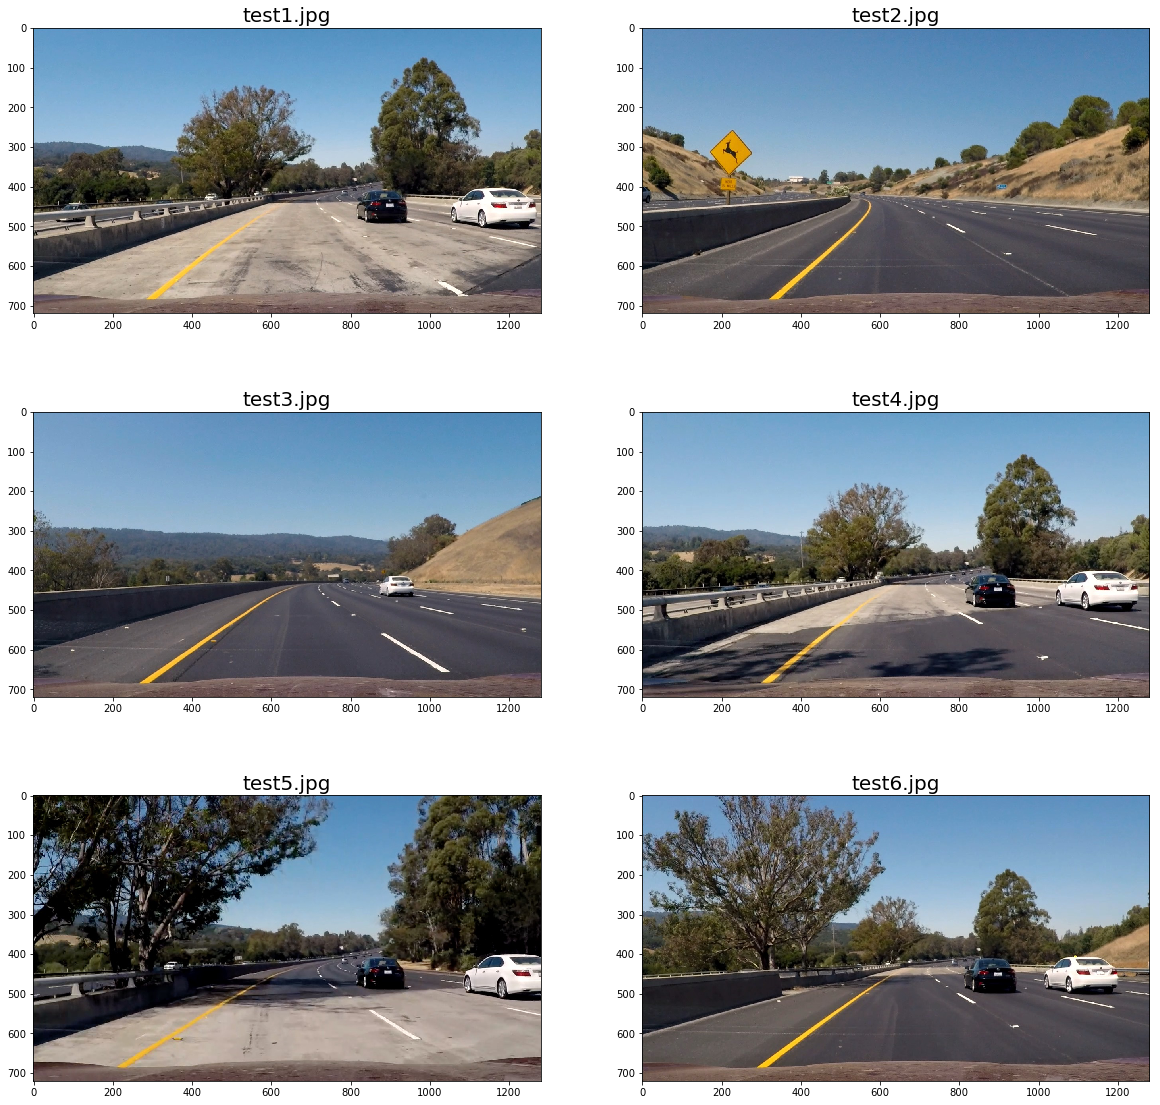

In [14]:
def showTestImages():
    images, titles = getImages(FNAMES)
    display(images, titles=titles, axis='on')

if __name__=="__main__":
    showTestImages()

In [15]:
def convert_color(img, conv='BGR'):
    color = 'cv2.COLOR_RGB2' + conv
    if (conv == 'RGB'):
        color = '1'
    cnvt_img = cv2.cvtColor(img, eval(color))
    return cnvt_img

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def bin_spatial_show(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size)
    color2 = cv2.resize(img[:,:,1], size)
    color3 = cv2.resize(img[:,:,2], size)
    return color1, color2, color3
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                                         cell_per_block, vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                                cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

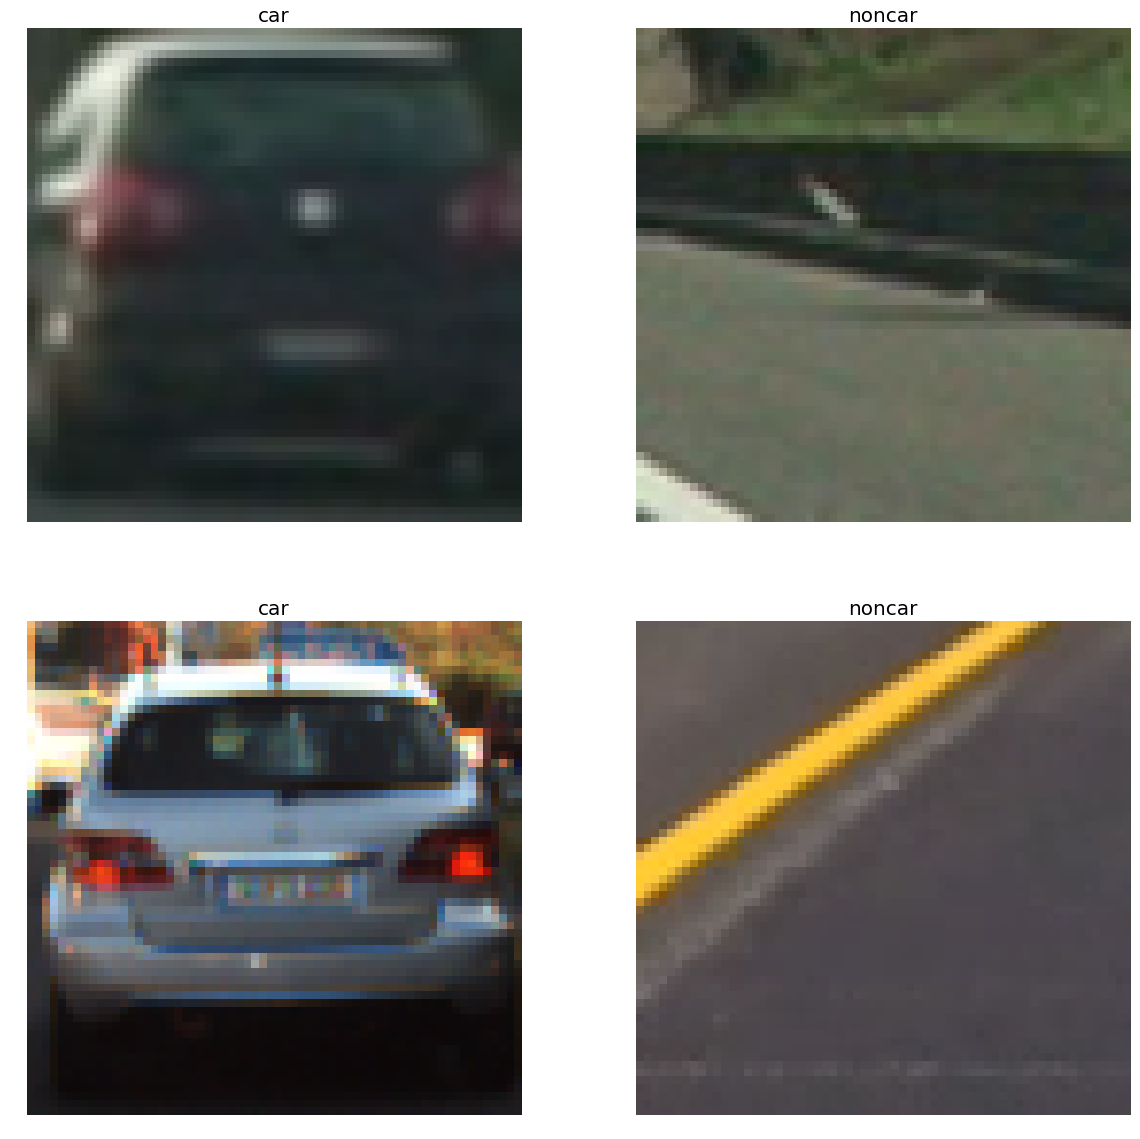

In [16]:
def showCarNonCar():
    images = []
    for i in range(2):
        images.append(mpimg.imread(random.choice(CARF)))
        images.append(mpimg.imread(random.choice(NONCARF)))
    display(images, k=2, titles=['car', 'noncar', 'car', 'noncar'])

if __name__=="__main__":
    showCarNonCar()

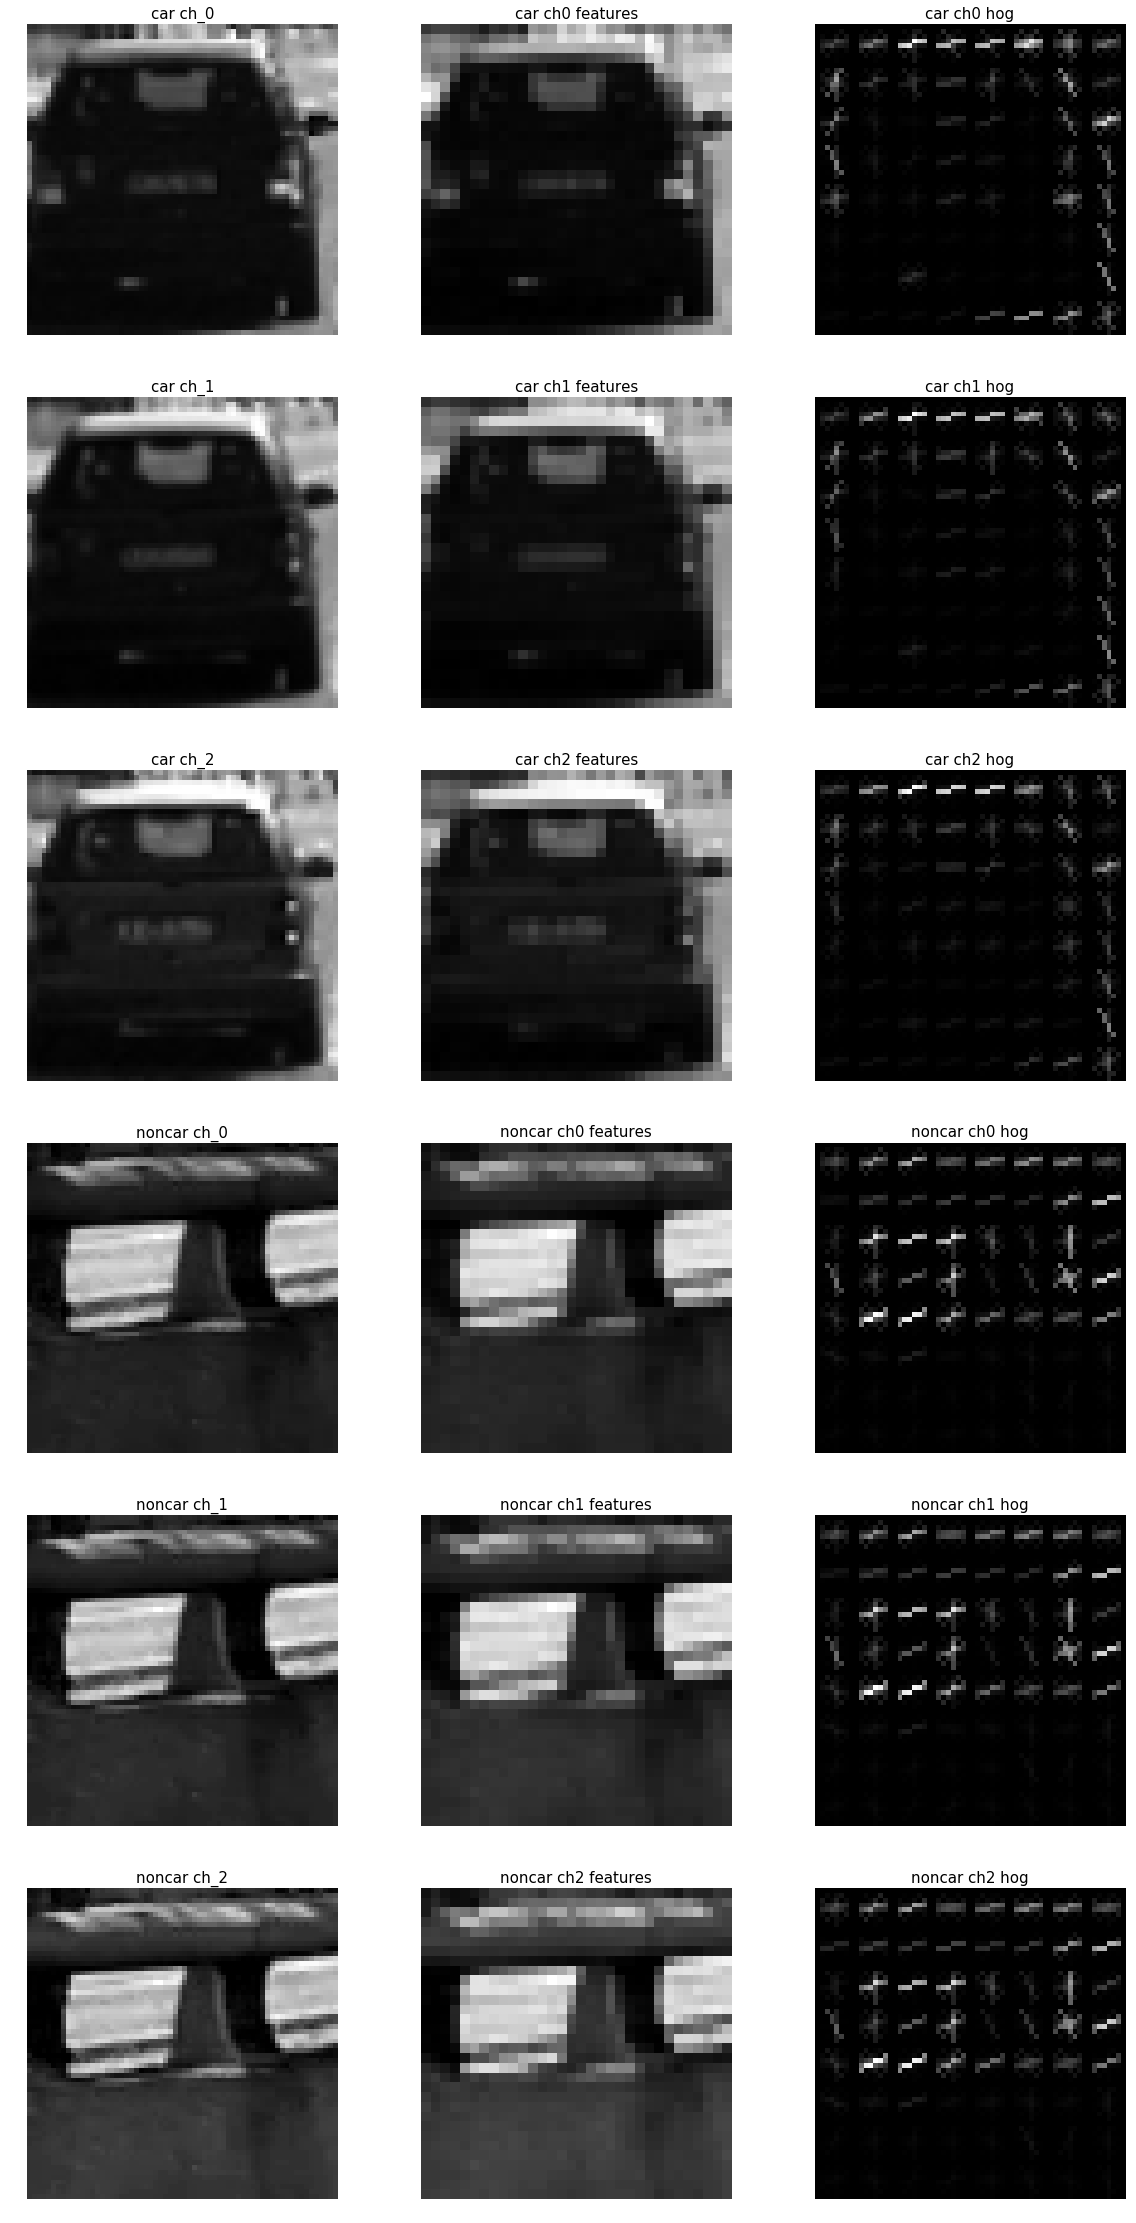

In [24]:
def showHogFeatures():
    car = mpimg.imread(random.choice(CARF))
    noncar = mpimg.imread(random.choice(NONCARF))
    
    carch0_f, carch1_f, carch2_f = bin_spatial_show(car)
    noncarch0_f, noncarch1_f, noncarch2_f = bin_spatial_show(noncar)
    
    carch0 = car[:,:,0]
    carch0_hf, carch0_hog = get_hog_features(carch0, vis=True, feature_vec=False)
    carch1 = car[:,:,1]
    carch1_hf, carch1_hog = get_hog_features(carch1, vis=True, feature_vec=False)
    carch2 = car[:,:,2]
    carch2_hf, carch2_hog = get_hog_features(carch2, vis=True, feature_vec=False)
    
    noncarch0 = noncar[:,:,0]
    noncarch0_hf, noncarch0_hog = get_hog_features(noncarch0, vis=True, feature_vec=False)
    noncarch1 = noncar[:,:,1]
    noncarch1_hf, noncarch1_hog = get_hog_features(noncarch1, vis=True, feature_vec=False)
    noncarch2 = noncar[:,:,2]
    noncarch2_hf, noncarch2_hog = get_hog_features(noncarch2, vis=True, feature_vec=False)
    
    images = [carch0, carch0_f, carch0_hog, carch1, carch1_f, carch1_hog, carch2, carch2_f, carch2_hog,
              noncarch0, noncarch0_f, noncarch0_hog, noncarch1, noncarch1_f, noncarch1_hog, noncarch2, 
              noncarch2_f, noncarch2_hog]
    titles = ['car ch_0', 'car ch0 features', 'car ch0 hog', 'car ch_1', 'car ch1 features', 'car ch1 hog',
             'car ch_2', 'car ch2 features', 'car ch2 hog', 'noncar ch_0', 'noncar ch0 features', 'noncar ch0 hog',
             'noncar ch_1', 'noncar ch1 features', 'noncar ch1 hog', 
             'noncar ch_2', 'noncar ch2 features', 'noncar ch2 hog']
    display(images, titles=titles, k=3, figsize=(20,40), cmap='gray', fontsize=15)

if __name__=="__main__":
    showHogFeatures()